# Blood Cell Type Image Classification using Transfer Learning (MobilenetV2)

In [1]:
# Import modules

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report 
from tensorflow.keras import layers, models

In [2]:
# Check if GPU available
if gpu_available := tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    print(f"Is built with Cuda: {tf.test.is_built_with_cuda()}")
else:
    print("GPU is not available.")

GPU is available.
Is built with Cuda: True


In [3]:
# define data directory
train_dir = 'dataset2-master/dataset2-master/images/TRAIN'
test_dir = 'dataset2-master/dataset2-master/images/TEST'

# global variables
seed = 42

## Data Preprocessing
1. Loading Image data

In [4]:
# Create Generators for train and test

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

2. Flow from directory

In [16]:
train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True, # important that you shuffle the order during training
    seed= seed,
    subset='training',
)

val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed= seed,
    subset='validation',
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False, # important that you NOT shuffle for test to not mess up the labeling
    seed=seed,
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [6]:
# take a look at the image data
# train_images.next()[0] # the image data
train_images.next()[1] # the label data

# we notice that the label is one hot encoded already

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

## Build Pretrained Model

In [7]:
pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='max', # you can also try avg pooling
)

pretrained_model.trainable = False 
# we dont want to train the pretrained model because they have been already optimized on Imagenet dataset

# Define classification model

inputs = pretrained_model.input
#add 1 FC layer to the pretrained model
x = layers.Dense(256, activation='relu', name= 'my_fc')(pretrained_model.output) # 256 neurons, you can try other values too
outputs = layers.Dense(4, activation='softmax', name = 'my_outputlayer')(x) # because output classes are 4

model = models.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # not using sparse_categorical_crossentropy because label is 1 hot encoded
    metrics=['accuracy'],
    
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Model visualization

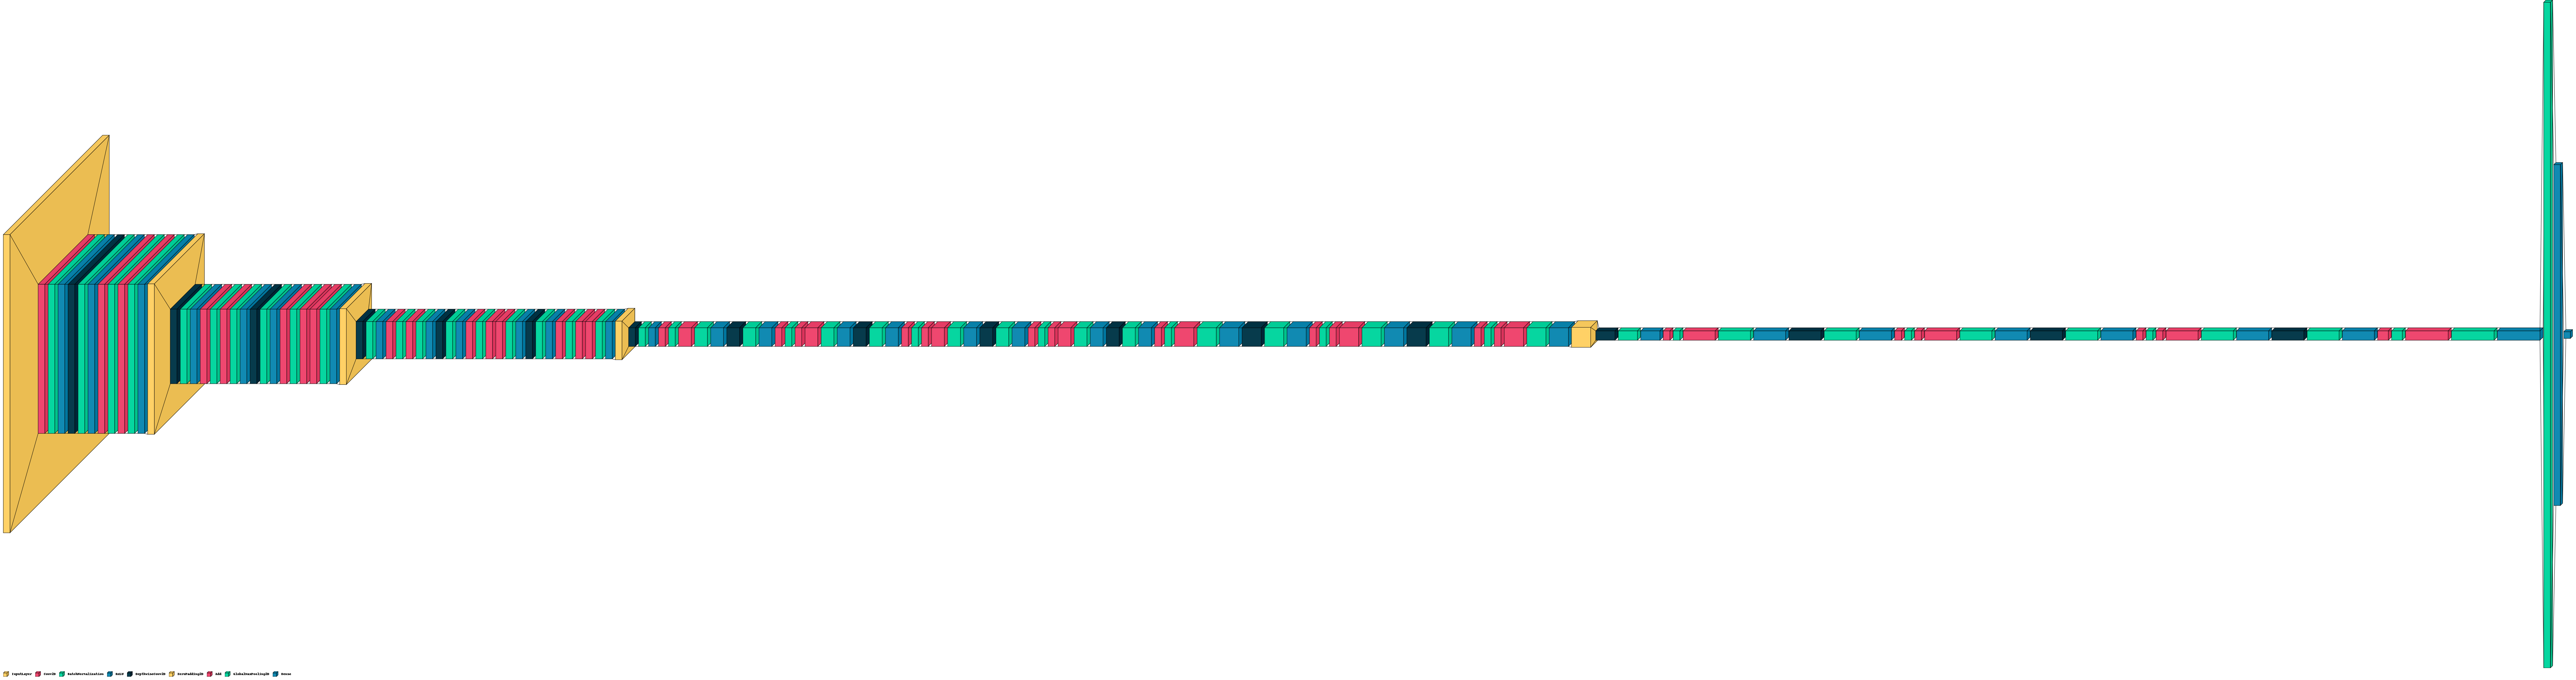

In [8]:
import visualkeras as vk
vk.layered_view(model, legend=True, one_dim_orientation='y', to_file='model_using_mobilenet_v2.png') # save the image as png

from IPython.display import Image
Image(filename='model_architecture.png') 


# Note below that we made a fairly complex and deep architecture without even thinking about the filter size and number of convolutions.
# This is the benefit of Transfer learning where we are using a 
# optimized CNN architecture which is good at learning from image data.
# Also, we will notice that when training even for very few epochs we already able to achieve very high accuracy.



Training the model

In [9]:
epochs = 15
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(   # stop training when validation loss stops improving 
            patience=5,                     # after 5 consecutive epochs of no improvement
            restore_best_weights=True)]
)

Epoch 1/15
249/249 [==============================] - 21s 68ms/step - loss: 1.3413 - accuracy: 0.5664 - val_loss: 0.8095 - val_accuracy: 0.6707
Epoch 2/15
249/249 [==============================] - 16s 63ms/step - loss: 0.6494 - accuracy: 0.7362 - val_loss: 0.5843 - val_accuracy: 0.7722
Epoch 3/15
249/249 [==============================] - 16s 63ms/step - loss: 0.5230 - accuracy: 0.7978 - val_loss: 0.7087 - val_accuracy: 0.6908
Epoch 4/15
249/249 [==============================] - 16s 64ms/step - loss: 0.4402 - accuracy: 0.8249 - val_loss: 0.6448 - val_accuracy: 0.7386
Epoch 5/15
249/249 [==============================] - 16s 66ms/step - loss: 0.3896 - accuracy: 0.8499 - val_loss: 0.4769 - val_accuracy: 0.8100
Epoch 6/15
249/249 [==============================] - 16s 66ms/step - loss: 0.3462 - accuracy: 0.8662 - val_loss: 0.5543 - val_accuracy: 0.7748
Epoch 7/15
249/249 [==============================] - 15s 61ms/step - loss: 0.2885 - accuracy: 0.8886 - val_loss: 0.4353 - val_accuracy:

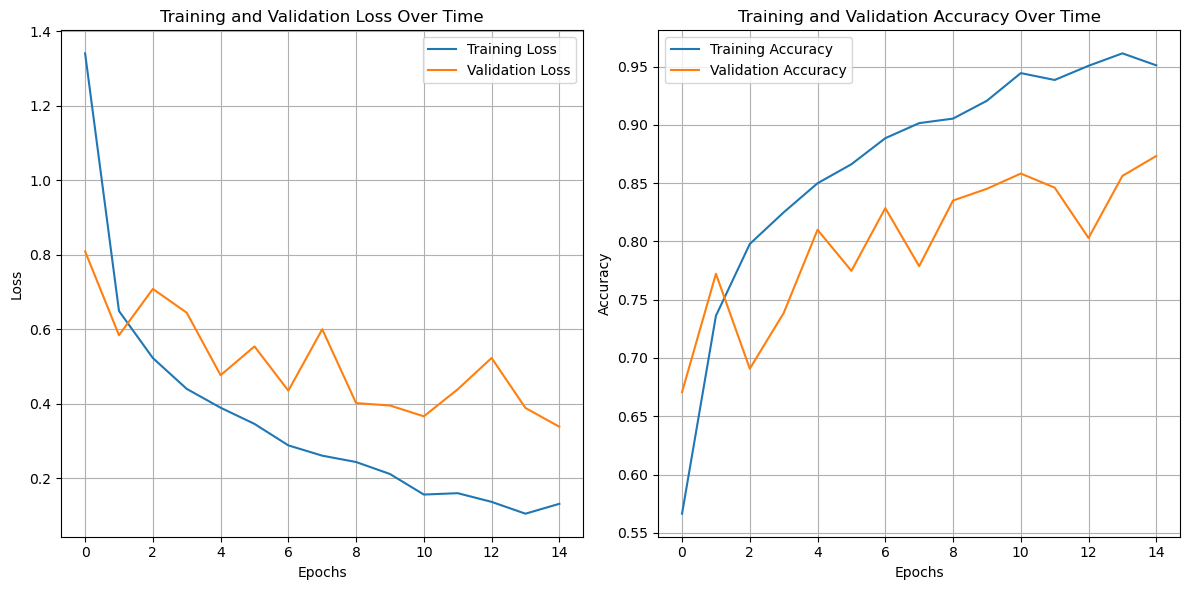

In [10]:
# Plotting Training and Validation Loss and accuracy

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot the training and validation loss 
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss Over Time')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot the training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy Over Time')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Evaluating Results

In [11]:
class_names = list(train_images.class_indices.keys())
class_names

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

78/78 [==============================] - 4s 49ms/step
Test accuracy: 52.031


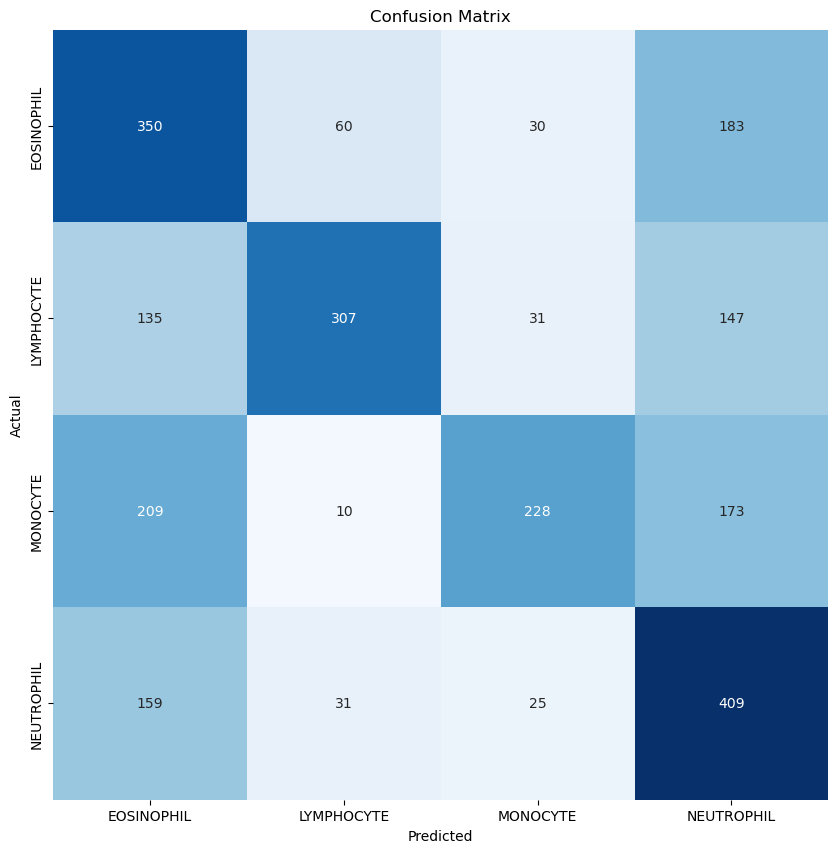

classification_report: ............................. 
              precision    recall  f1-score   support

  EOSINOPHIL       0.41      0.56      0.47       623
  LYMPHOCYTE       0.75      0.50      0.60       620
    MONOCYTE       0.73      0.37      0.49       620
  NEUTROPHIL       0.45      0.66      0.53       624

    accuracy                           0.52      2487
   macro avg       0.58      0.52      0.52      2487
weighted avg       0.58      0.52      0.52      2487



In [12]:
predictions = np.argmax(model.predict(test_images), axis=1)
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
report = classification_report(test_images.labels, predictions, target_names=class_names)
print(f"Test accuracy: {acc*100:.3f}")

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', vmin =0, cmap= 'Blues', cbar=False)
plt.xticks(ticks=np.arange(4)+ 0.5, labels=class_names)
plt.yticks(ticks=np.arange(4)+ 0.5, labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f"classification_report: ............................. \n{report}")

## Investigating Poor Test Set Performance

The test set performance is subpar, particularly for the 'NEUTROPHIL' and 'EOSINOPHIL' class, with an accuracy of about 50%, which is equivalent to flipping a coin. On the other hand, the validation accuracy consistently surpasses 90%, and both training and validation loss continue to decrease with each epoch.

To gain further insights, let's plot the confusion matrix for the validation set. Prior to running the below code, ensure that you set `shuffle = False` for `val_images`.


63/63 [==============================] - 3s 46ms/step
Validation accuracy: 87.330


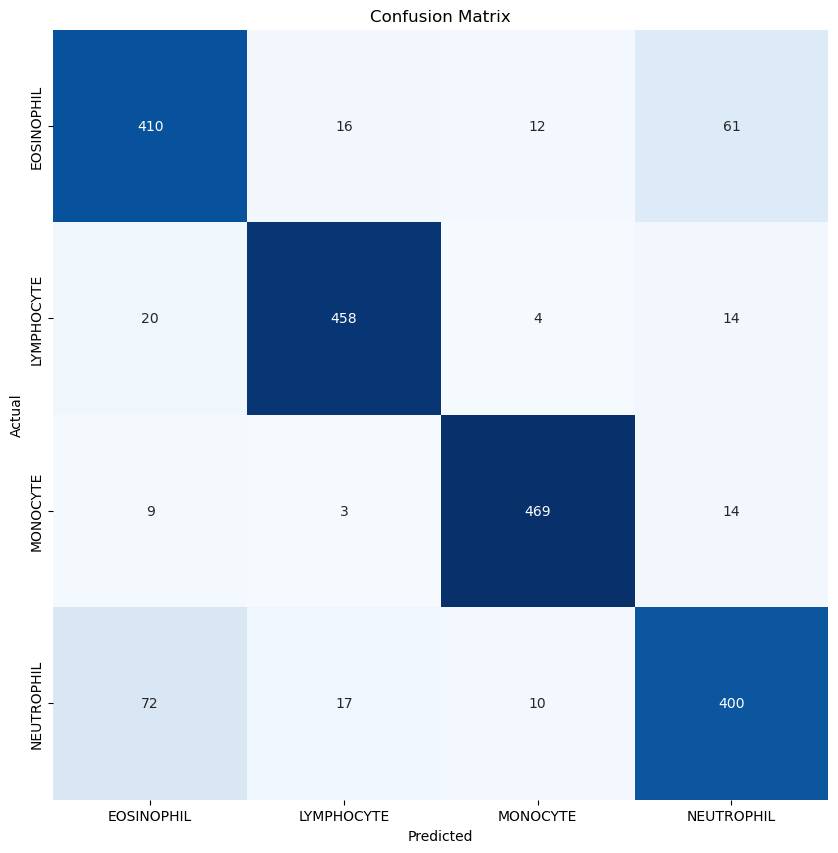

classification_report: ............................. 
              precision    recall  f1-score   support

  EOSINOPHIL       0.80      0.82      0.81       499
  LYMPHOCYTE       0.93      0.92      0.93       496
    MONOCYTE       0.95      0.95      0.95       495
  NEUTROPHIL       0.82      0.80      0.81       499

    accuracy                           0.87      1989
   macro avg       0.87      0.87      0.87      1989
weighted avg       0.87      0.87      0.87      1989



In [15]:
predictions = np.argmax(model.predict(val_images), axis=1)
acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
report = classification_report(val_images.labels, predictions, target_names=class_names)
print(f"Validation accuracy: {acc*100:.3f}")

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', vmin =0, cmap= 'Blues', cbar=False)
plt.xticks(ticks=np.arange(4)+ 0.5, labels=class_names)
plt.yticks(ticks=np.arange(4)+ 0.5, labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f"classification_report: ............................. \n{report}")

### Conclusion from Validation Set Results

The high accuracy of 94.5% achieved on the validation images leads to two possible conclusions:

1. It is highly probable that the test data contains mislabeled samples.
2. Alternatively, the test set may have been generated using a different process than the original training set.

This conclusion arises from the fact that when working with pre-split train and test data, there is no guarantee that the image quality or type in the train set matches that of the test set. Looking at the confusion matrix, It is possible that the neutrophil class in the test set contains mixed samples from other classes.